In [1]:
from pathlib import Path
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from s4hci.utils.fwhm import get_fwhm
from applefy.utils.file_handling import load_adi_data

from s4hci.utils.data_handling import read_s4hci_root_dir
from s4hci.models.psf_subtraction import S4

# Datasets of interest

In [29]:
# Dataset setups (Name of the dataset, dit_psf, dit_science, ND scaling)
datasets = [ 
    ("HD22049_310_0100_C-0656_A_", 0.0042560, 0.08, 1.0),
    ("HD22049_351_096_C-0679_A_", 0.0042560, 0.08, 1.0),
    ("HD22049_303_199_C-0065_C_", 0.0042560, 0.08, 1.0),
    ("HD115892_143_1101_C-0092_E_", 0.008, 0.35, 1.0),
    ("HD169022_140_1101_C-0092_E_", 0.005, 0.35, 1.0),
    ("HD209952_196_089_C-0149_A_", 0.04, 0.2, 55.87),
    ("HD38678_331_084_C-0396_A_", 0.2, 0.2, 55.87),
    ("HD71155_338_088_C-0085_A_", 0.2, 0.2, 55.87),
    ("HD7570_331_1101_C-0092_C_", 0.02, 0.35, 1.0),
    
    ("HD11171_332_1101_C-0092_C_", 0.02, 0.35, 1.0),
    ("HD135379_220_1101_C-0092_I_", 0.02, 0.35, 1.0),
    ("HD14228_210_085_C-0675_A_", 0.2, 0.2, 55.87),
    ("HD177724_231_091_C-0654_A_", 0.08, 0.2, 55.87),
    ("HD2262_305_199_C-0065_C_", 0.02, 0.35, 1.0),
    ("HD27290_348_198_C-0612_C_", 0.02, 0.35, 1.0),
    ("HD40136_333_1101_C-0092_C_", 0.01, 0.3, 1.0),
]

In [132]:
# select one dataset
dataset_name, dit_psf, dit_science, nd_scaling  = datasets[15]
pixel_scale=0.02718
dataset_name

'HD40136_333_1101_C-0092_C_'

# Load the dataset

In [133]:
root_dir = Path(read_s4hci_root_dir())

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [134]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [135]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [136]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [137]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# Parameter 1: FWHM

In [138]:
fwhm = get_fwhm(psf_template)
#fwhm = 3.6
fwhm

3.6

# Parameter 2: $\lambda$

In [139]:
# 2.) Create the model
s4_model = S4(
    science_cube=science_data,
    adi_angles=angles,
    psf_template=psf_template,
    device="cpu",
    work_dir=None,
    noise_cut_radius_psf=fwhm,
    noise_mask_radius=fwhm * 1.5,
    verbose=True,
    noise_model_lambda_init=1e3)

In [140]:
svd_approx = int(np.min([science_data.shape[0], science_data.shape[1]**2])* 0.7)
svd_approx

2837

In [141]:
lambdas = np.logspace(1, 8, 500)
all_results, best_lambda = s4_model.validate_lambdas_noise(
    num_separations=10, 
    lambdas=lambdas,
    num_test_positions=10,
    test_size=0.3,
    approx_svd=svd_approx)

S4 model: validating noise model ... S4 Noise: validating noise model ... Compute validation positions for separation 4.090909090909091 ...
Compute betas for separation 4.090909090909091 ...


 10%|████████████████▊                                                                                                                                                       | 1/10 [00:23<03:29, 23.29s/it]


KeyboardInterrupt: 

## check the result with a plot

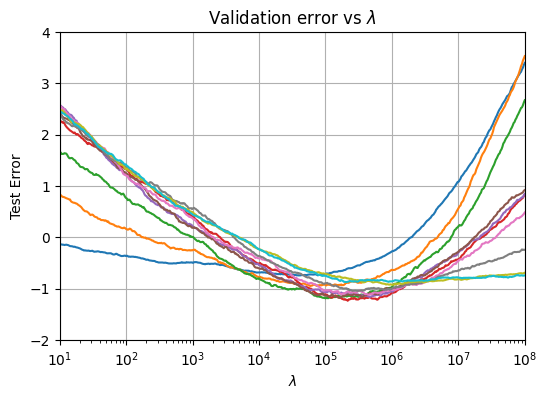

In [201]:
merged_results = np.array([i for i in all_results.values()])
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

ax1.plot(lambdas, np.array(merged_results).T)
ax1.set_title(r"Validation error vs $\lambda$")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("Test Error")
ax1.set_xscale("log")
ax1.grid()
ax1.set_ylim(-2, 4)
ax1.set_xlim(1e1, 1e8)
plt.show()

In [202]:
separations = np.array(list(all_results.keys()))
best_lambdas = np.array([lambdas[list(all_results.values())[i].argmin()] 
                         for i in range(len(separations))])

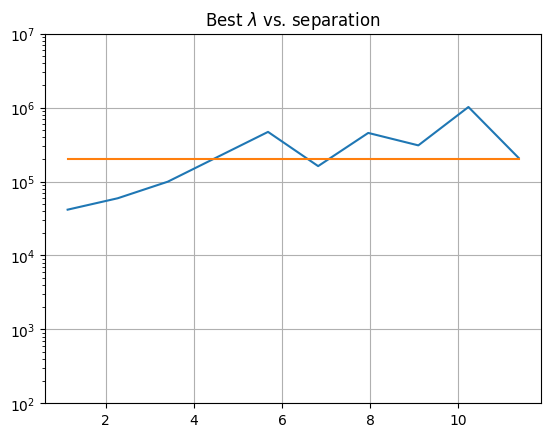

In [203]:
x = separations
y = best_lambdas
z = np.polyfit(x, np.log(y), 0)
p = np.poly1d(z)

plt.plot(separations / 3.6, best_lambdas)
plt.plot(separations / 3.6, np.exp(p(separations)))
plt.title("Best $\lambda$ vs. separation")
plt.yscale("log")
plt.ylim(1e2, 1e7)
plt.grid()

# Save the parameters as json

In [97]:
best_lambda = 100

In [142]:
import json

In [143]:
parameter_dict = {
    "dataset_name" : dataset_name,
    "dit_psf" : dit_psf,
    "dit_science" : dit_science,
    "nd_scaling" : nd_scaling,
    "pixel_scale" : pixel_scale,
    "fwhm" : fwhm,
    "svd_approx" : svd_approx,
    "lambda_reg" : best_lambda,
    "num_epochs" : 500}

In [145]:
parameter_dict

{'dataset_name': 'HD40136_333_1101_C-0092_C_',
 'dit_psf': 0.01,
 'dit_science': 0.3,
 'nd_scaling': 1.0,
 'pixel_scale': 0.02718,
 'fwhm': 3.6,
 'svd_approx': 2837,
 'lambda_reg': 100,
 'num_epochs': 500}

In [146]:
with open(root_dir / Path("30_data/" + dataset_name + ".json"), 'w', encoding='utf-8') as f:
    json.dump(parameter_dict, f, ensure_ascii=False, indent=4)